/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

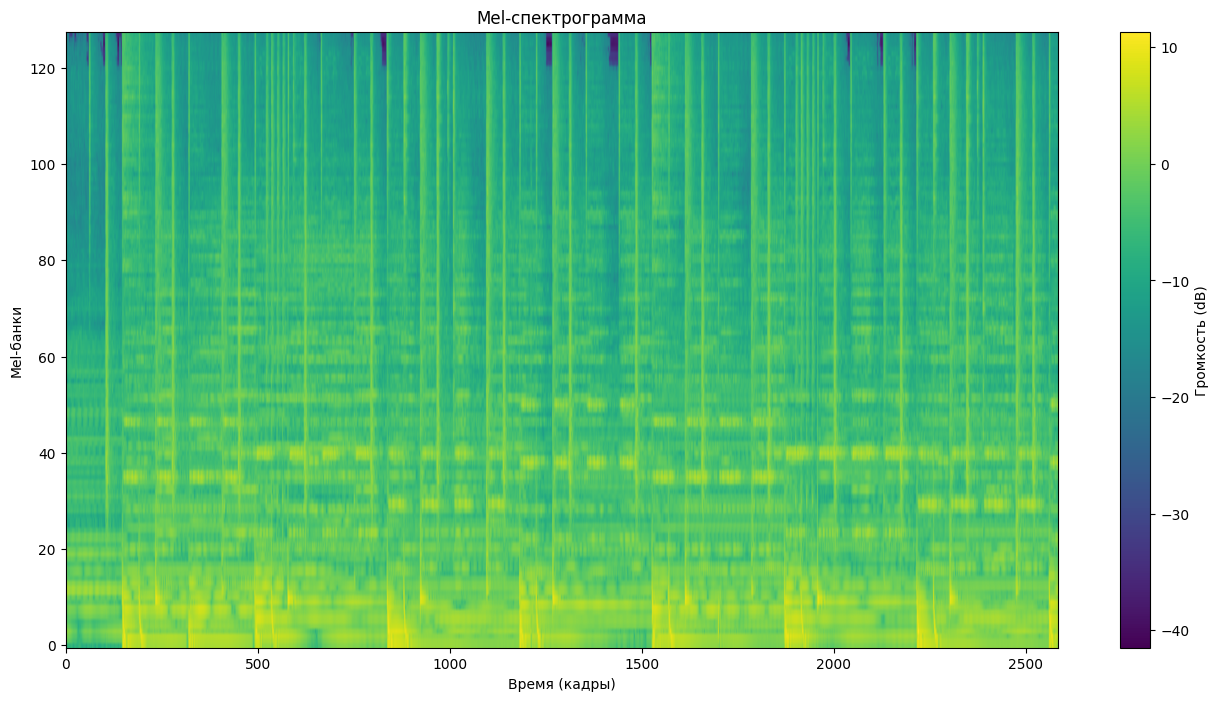

In [2]:
import torchaudio
import torch
import matplotlib.pyplot as plt

def preprocess_audio(audio_path, target_sr = 22050) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    #уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_mels=128,        
        n_fft=1024,       
        hop_length=256,
        f_min=20,
        f_max=11025
    )(waveform)
    return mel_spectrogram

mel_spektr = preprocess_audio("../data/train/00/7400.mp3")

#mel-спектрограмма
plt.figure(figsize=(16, 8))
plt.imshow(mel_spektr.log2()[0,:,:].numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Громкость (dB)')
plt.title("Mel-спектрограмма")
plt.xlabel("Время (кадры)")
plt.ylabel("Mel-банки")
plt.show()